# Deep Neural Network for MNIST Classification
#### by Sooyeon Won 


### Keywords 
- Deep Neural Network
- MNIST Classification
- Train, Validate, Test


### Contents 

<ul>
<li><a href="#Introduction">1.  Introduction</a></li>
<li><a href="#Preparation">2.  Data Preparation</a></li>
<li><a href="#Modelling">3.  Modelling</a></li>
<li><a href="#Test">4.  Test the Model</a></li>

</ul>




<a id='Introduction'></a>
## 1. Introduction


![image-3.png](attachment:image-3.png )

The dataset is called MNIST and refers to handwritten digit recognition. book). The dataset provides 70,000 images (28x28 pixels) of handwritten digits (1 digit per image). 

The goal is to write an algorithm that detects which digit is written. Since there are only 10 digits (0, 1, 2, 3, 4, 5, 6, 7, 8, 9), this is a classification problem with 10 classes. The goal would be to build a neural network with 2 hidden layers.
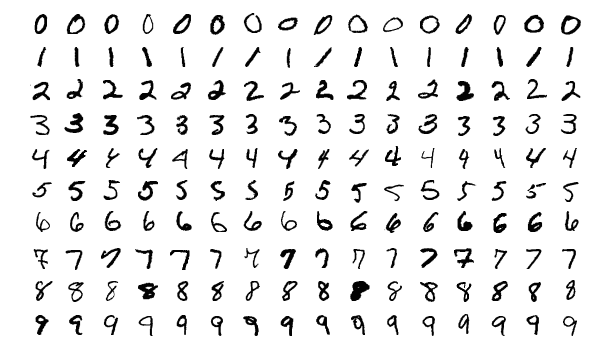

<a id='Preparation'></a>
## 2. Data Preparation

In [1]:
# Import the relevant packages
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds 

> TensorFLow includes a data provider for MNIST that I used for this analysis. It comes with the tensorflow-datasets module.

In [2]:
# Generally, 
#mnist_dataset = tfds.load(name='mnist', as_supervised=True)

# Alternatively, 
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

> In general, 'tfds.load' loads a dataset. For this analysis I am interested in the 'mnist'; the name of the dataset is the only mandatory argument. I specified additonal arguments 
>- with_info=True: This provides a tuple containing information about the version, features, number of samples. I use this information a bit below and store it in mnist_info. 
>- as_supervised=True: This allows to load the dataset in a 2-tuple structure (input, target), On the other hand, "as_supervised=False" would return a dictionary. Since I prefer to have the inputs and targets separated. 


In [3]:
# To extract the training and testing dataset with the built references
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test'] 


## Validation set ######
# Define the size of validation samples
num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
# Assign the defined number with integer format
num_validation_samples = tf.cast(num_validation_samples, tf.int64)


## Test set ######
# Define the size of test samples
num_test_samples = mnist_info.splits['test'].num_examples
# Assign the defined number with integer format
num_test_samples = tf.cast(num_test_samples, tf.int64)

> By default, tensorflow has training and testing datasets, only. Since it has no validation sets, I split it on my own. 
>- First, I defined the number of validation samples as 10 % of the train samples. This is also where I make use of mnist_info, since I don't need to count the observations. Then I casted the defined number to an integer, sicne a float type may cause an error. 
>- The same process is applied to the testset. I defined the number of test samples in a dedicated variable, but this time, instead of using the mnist_info one.Once more, I prefer an integer, rather than the float.

In [4]:
def scale(image, label):
    
    image = tf.cast(image, tf.float32) # Make sure the value is a float 
    
    image /= 255.  # Scale the value -> between 0 and 1 

    return image, label

> All possible values for the inputs are 0 to 255 (256 different shades of grey). By dividing each element by 255, I can scale all elements will be between 0 and 1. The reason I scaled the data points is to make the result more numerically stable. To do so, I define a function called: scale. that is supposed to take an MNIST image and its label. 


In [5]:
# Scale the training data samples
scaled_train_and_validation_data = mnist_train.map(scale) 

# Scale the test data samples 
test_data = mnist_test.map(scale)

>- Using the ".map()" method, I applied a custom transformation to the given datasets: mnist_train, mnist_test. Note that the validation data is a part of mnist_train. 
>- Finally, I scaled and batched the test data. I scaled  the test data too, so that it has the identical  magnitude as the train and validation samples. 
>- Since I will not train the model on the test data, shuffling for test samples are not required. There would be a single batch, equal to the size of the test data.



In [6]:
# Set the buffer size
BUFFER_SIZE = 10000

# Shuffle the train datasets
shuffled_train_and_validation_data = scaled_train_and_validation_data.shuffle(BUFFER_SIZE)

> I shuffled the train and validation dataset, by setting a parameter, namely BUFFER_SIZE. 
>- If **BUFFER_SIZE = 1**, shuffling will not be progressed : Stochastic gradient descent (SGD)
>- if **BUFFER_SIZE >= # of Samples**, shuffling is uniform : Single batch
>- if **1 < BUFFER_SIZE < # of Samples**, a computational optimization to approximate uniform shuffling occurs: Mini_batch GD

> The  parameter is generally useful when we're dealing with enormous datasets. In this case, we can't shuffle the whole dataset in one go because we can't fit it all in memory, so instead TensorFlow only stores BUFFER_SIZE samples in memory at a time and shuffles them.  
> I made use of the '.shuffle()' method. To specify the buffer size is required only. 


In [7]:
# Split validation data from train data
validation_data = shuffled_train_and_validation_data.take(num_validation_samples)

train_data = shuffled_train_and_validation_data.skip(num_validation_samples)

>- Now, I have scaled and shuffled the data. I extracted the validation from the train datasets. The validation data would be equal to 10% of the training set. To do so, I used the .take() method. Finally, I created a batch with a batch size equal to the total number of validation samples. 
>- Similarly, the train_data is everything else, so I skipped as many samples as there are in the validation dataset

In [8]:
# Determine the batch size
BATCH_SIZE = 100

# Batch the train and validation data
train_data = train_data.batch(BATCH_SIZE)
validation_data = validation_data.batch(num_validation_samples)

# Batch the test data
test_data = test_data.batch(num_test_samples)

# Takes next batch (it is the only batch), since as_supervized=True, I have got a 2-tuple structure
validation_inputs, validation_targets = next(iter(validation_data))

>- I also took advantage of the occasion to batch the train data. This would be useful when I train, as I could iterate over the different batches. The method ".batch()" combines the conservative elements of a dataset into batches.
>- Note that the validation data must have the same shape & the object properties as the train & test data. 
>- When batching, we usually find the average loss and average accuracy. During **Validating & Testing**, we want however, the exact values. Thus, we should take all the data at once. 
> For Validating and Testing, we conduct a forward-propagation which does not require high computational power. Thus, It is not expensive to calculate the exact values. 
> However, the model expects the validation data with the validation dataset in batch from too. This we should overwrite the validation data, using the method ".batch()". 
> In this way, I created a new column in the tensor, indicating that the model takes the whole dataset at once. 

>- **.iter()** method creates an object which can be iterated 1 element at a time. By default it makes the dataset iterable, but will not load any data. 
>- **.next()** method loads the next element of an iterable object. Since there is a only 1 batch, it will load the inputs and the targets. 

<a id='Modelling'></a>
## 3. Modelling

### 3. 1. Outline the model
Building the model is all about deep learning algorithms.

In [9]:
# Set the sizes of input, output and hidden layers. 
input_size = 784
output_size = 10

#  In this analysis I set the same size of hidden layer for both hidden layers. But this is not necessary. 
hidden_layer_size = 50

In [10]:
model = tf.keras.Sequential([
                            # Input layer
                            tf.keras.layers.Flatten(input_shape=(28, 28, 1)), 
                            # 1st hidden layer 
                            tf.keras.layers.Dense(hidden_layer_size, activation='relu'), 
                            # 2nd hidden layer
                            tf.keras.layers.Dense(hidden_layer_size, activation='relu'), 
                            # Output layer with softmax function
                            tf.keras.layers.Dense(output_size, activation='softmax') # output layer
])

>- The first layer is the input layer. Each observation is 28x28x1 pixels, therefore it is a tensor of rank 3. Since this course haven't covered CNNs yet, I flattened the images, instead of feeding the inputs into the net, using  "Flatten" method which takes the (28x28x1) tensors and orders it into a (None,) or a (28x28x1,) = (784,) vector. This allows to  create a feed forward neural network.

>- Note that **tf.keras.layers.Dense** basically implements: output = activation(dot(input, weight) + bias). It takes several arguments, but the most important ones are the hidden_layer_size and the activation function. For this simple analysis, I set the identical activation functions for the two hidden layers, but in practice, each neural network has a differrent optimal combination of activation functions. 

>- The final layer is no different, I just make sure to activate it with softmax. When creating a classifer, the activation function of the output layer much transform the values into probabilities. Therefore, I opted for the softmax. 

### 3. 2. Choose the optimizer and the loss function

In [11]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

>I specified the optimizer, the loss and the metrics through the compile method. **.compile()** method configures the model for training. 
> 1. I selected the **Optimizer**: adam (Adaptive Moment Estimation), which is a most recently developed methodology.
> 2. For the **Loss function**: 'Cross-Entropy' is mostly used. However, various types of 'Cross-Entropy' exist in tensorflow2. <br>
> For example, **Binary Cross-Entropy** refers to the case we have binary encodings. **Categorical Cross-Entropy** expects that we have one-hot encoded the targets. **Sparse Categorical Cross-Entropy**, which is almost equivalent to the previous one, applies one-hot encoding. <br>
> Although I did not conduct one-hot encoding in the previous data preparation section, the output in the target layer should have matching forms. The model and Optimizer expect the output shape to match the target shape in a one-hot encoding format. Thus, I chose the 'Sparse Categorical Cross-Entropy'.
> 3. The complie method allows to include **Metrics** that I want to calculate throughout the training & testing processes. 

### 3. 3. Training
>- Here I trained (= fitted) the model, specifying the training data, the total number of epochs, and the validation data we just created ourselves in the format: (inputs,targets).  
>- Whenever I have hyperparameters that I have to set a specific value, it is better to create dedicated variables. This way I can easily spot when I find tunes or debugs my codes. 

In [12]:
# Determine the maximum number of epochs
NUM_EPOCHS = 10

# Fit the model
model.fit(train_data, epochs=NUM_EPOCHS, validation_data=(validation_inputs, validation_targets), verbose =2)

Epoch 1/10
540/540 - 6s - loss: 0.4118 - accuracy: 0.8841 - val_loss: 0.2115 - val_accuracy: 0.9380
Epoch 2/10
540/540 - 9s - loss: 0.1735 - accuracy: 0.9509 - val_loss: 0.1550 - val_accuracy: 0.9558
Epoch 3/10
540/540 - 5s - loss: 0.1333 - accuracy: 0.9611 - val_loss: 0.1113 - val_accuracy: 0.9693
Epoch 4/10
540/540 - 5s - loss: 0.1080 - accuracy: 0.9680 - val_loss: 0.1004 - val_accuracy: 0.9710
Epoch 5/10
540/540 - 5s - loss: 0.0893 - accuracy: 0.9731 - val_loss: 0.0942 - val_accuracy: 0.9735
Epoch 6/10
540/540 - 5s - loss: 0.0789 - accuracy: 0.9769 - val_loss: 0.0849 - val_accuracy: 0.9758
Epoch 7/10
540/540 - 8s - loss: 0.0681 - accuracy: 0.9795 - val_loss: 0.0738 - val_accuracy: 0.9783
Epoch 8/10
540/540 - 8s - loss: 0.0622 - accuracy: 0.9807 - val_loss: 0.0669 - val_accuracy: 0.9815
Epoch 9/10
540/540 - 6s - loss: 0.0541 - accuracy: 0.9835 - val_loss: 0.0637 - val_accuracy: 0.9833
Epoch 10/10
540/540 - 6s - loss: 0.0486 - accuracy: 0.9850 - val_loss: 0.0596 - val_accuracy: 0.9830

> 1. **540/540**: # of batchs 
> 2. **9s**: The time which took for each epoch to conclude
> 3. **loss:** Training loss, mostly decreasing, but not rapidly. This is because even after the first epoch, we have already had  540 weights and biases updates one for each batch. It should be compared across the epochs. 
> 4. **Training Accuracy:** This accuracy shows in what % of the cases the outputs were equal to the targets. It follows surely the trend of loss. 
> 5. **val_loss, val_accuracy:** Loss & Accuracy of the validation data. By keeping an eye on the validation loss (or set early-stopping mechanism), I can determine whether the model is overfitted.  

> Validation accuracy is the TRUE accuracy of the model for epochs. Note that the training accuracy is the average accuracy across batches. On the other hand, the validation accuracy is the average of the whole validation set. Thus, to assess the overall accuracy, we should check the validation accuracy for the last epoch. 

> The accuracy can be updated by changing the number of hidden layers, or the number of epochs. 

> **Inside process of each Epoch** <br>
> 1. At the begining of each epoch, the training loss will be set to zero. 
> 2. The algorithm will iterate over a pre-set number of batches, all from the training data. Basically, the whole training data set will be utilized, but in batches. 
> 3. Thus the weights and biases are updated as many times as there are batches. 
> 4. At the end of each epoch, we obtain a value of the loss function, indicating how training is processing. 
> 5. We also obtain a training accuracy. 
> 6. At the end of the epoch, the algorithm will forward-propagate the whole validation set in a single batch, through the optimized model & calculate the validation accuracy. 
> 7. Finally, when we reach the maximum number of epochs the training will be over. 

<a id='Test'></a>
## 4. Test the model

> After training on the training data and validating on the validation data, I tested the final prediction power of the model by running it on the test dataset that the algorithm has NEVER seen before. 
<br><br>
> The accuracy previously mentioned is a validation accuracy, not the model accuracy. Important to note that fiddling with the hyperparameters can overfit the validation dataset.The model must be tested on the test dataset. So, the test is the absolute final instance. The accuracy we obtain on this stage is **the Accuracy of the algorithm**. 
<br><br>
If the model is adjusted after testing, overfitting starts on the test dataset, which will defeat its purpose.

In [13]:
test_loss, test_accuracy = model.evaluate(test_data)

1/1 [==============================] - 0s 3ms/step - loss: 0.0972 - accuracy: 0.9697


>- test_loss, test_accuracy should have the same format with train and validation sets. 
>- **.evaluate()** method returns the loss value & metrics valus for the model in the test set.

In [14]:
# Apply some nice formatting  (optional)
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

Test loss: 0.10. Test accuracy: 96.97%


>- The final test accuracy should be roughly around 97%. Each time the code is rerun, a different accuracy is obtained, since the batches are shuffled, or the weights are initialized in a different way, etc.
>- As eariler mentioned, after testing the model, we are conceptually no long allowed to changed the model. The main purpose of the test dataset is to simulate the model deployment. If the model performs poorly (e.g. 50% - 60% of test accuracy), it can be sure that the model has a overfitting, which leads a failure in real life too. 
>- Getting a value very close to the validation accuracy shows that the model is not overfitted. 
>- Finally, the test accuracy is the value that we expect to observe when the model is deployed in the real world.